In [1]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.tree import plot_tree
from sklearn.metrics import (accuracy_score, precision_score,
                             recall_score, f1_score)

In [2]:
SEED = 111
random.seed(SEED)
np.random.seed(SEED)

Будем учиться классифицировать жанры музыки, полузуюсь не аудио дорожками, а уже осмысленными признаками (правда, не все из них имеют понятные названия). Сами данные можно найти [здесь](https://www.kaggle.com/purumalgi/music-genre-classification). Будем использовать файл `train.csv`. Нашей задачей будет предсказание переменной `Class` (жанр песни) при помощи деревьев решений. Можно попробовать также другие методы классификации, которые мы прошли, и сравнить результаты. При обучении всех моделей не забывайте про разделение на тренировку и тест (или кросс валидацию [ссылка](https://www.youtube.com/watch?v=fSytzGwwBVw)).

### Задание 1. EDA (10 баллов)

Как обычно, начнем с того, что посмотрим на наши данные: типы переменных, пропущенные значения, баланс классов и все такое. Ваш ход:

In [56]:
data = pd.read_csv("../data/train.csv")
data.head()

,Artist Name,Track Name,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,time_signature,Class
0,Bruno Mars,That's What I Like (feat. Gucci Mane),60.0,0.854,0.564,1.0,-4.964,1,0.0485,0.017100,NaN,0.0849,0.8990,134.071,234596.0,4,5
1,Boston,Hitch a Ride,54.0,0.382,0.814,3.0,-7.230,1,0.0406,0.001100,0.004010,0.1010,0.5690,116.454,251733.0,4,10
2,The Raincoats,No Side to Fall In,35.0,0.434,0.614,6.0,-8.334,1,0.0525,0.486000,0.000196,0.3940,0.7870,147.681,109667.0,4,6
3,Deno,Lingo (feat. J.I & Chunkz),66.0,0.853,0.597,10.0,-6.528,0,0.0555,0.021200,NaN,0.1220,0.5690,107.033,173968.0,4,5
4,Red Hot Chili Peppers,Nobody Weird Like Me - Remastered,53.0,0.167,0.975,2.0,-4.279,1,0.2160,0.000169,0.016100,0.1720,0.0918,199.060,229960.0,4,10


#### **1. Посмотрим на данные вблизи.**

In [113]:
print('\033[1m' + "\nNumber of observations (rows):\n" + '\033[0m'f"{data.shape[0]}")
print('\033[1m' + "Number of parameters (columns):\n" + '\033[0m'f"{data.shape[1]}")


Number of observations (rows):
17996
Number of parameters (columns):
17


У нас 17996 наблюдений и 17 переменных.

#### **2. Теперь посмотрим на тип данных**

In [4]:
numerical_features = []
string_features = []
categorical_features = []
    
for column in data.columns:
    if data[column].nunique() <= 11:
        categorical_features.append(column)
    elif data[column].dtype in ['int64', 'float64']:
        numerical_features.append(column)
    elif data[column].dtype == 'object':
        string_features.append(column)

In [8]:
categorical_features

['key', 'mode', 'time_signature', 'Class']

In [9]:
string_features

['Artist Name', 'Track Name']

In [10]:
numerical_features

['Popularity',
 'danceability',
 'energy',
 'loudness',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo',
 'duration_min']

#### **3. А есть ли пропущенные значения?**

In [29]:
total_missing = data.isnull().sum().sum()
rows_with_missing = data[data.isnull().any(axis=1)].shape[0]
columns_with_missing = data.columns[data.isnull().any()].tolist()
    
print('\033[1m' + "\nTotal missing values:\n" + '\033[0m'f"{total_missing}")
print('\033[1m' + "Rows with missing values:\n" + '\033[0m'f"{rows_with_missing}")
print('\033[1m' + "Columns with missing values:\n" + '\033[0m'f"{columns_with_missing}")


Total missing values:
6819
Rows with missing values:
6183
Columns with missing values:
['Popularity', 'key', 'instrumentalness']


In [51]:
na_values = (data.isna().sum() / len(data)).to_frame(name='NA Rate')
na_values = na_values[na_values['NA Rate'] > 0].dropna()

In [54]:
na_values

,NA Rate
Popularity,0.023783
key,0.111914
instrumentalness,0.243221


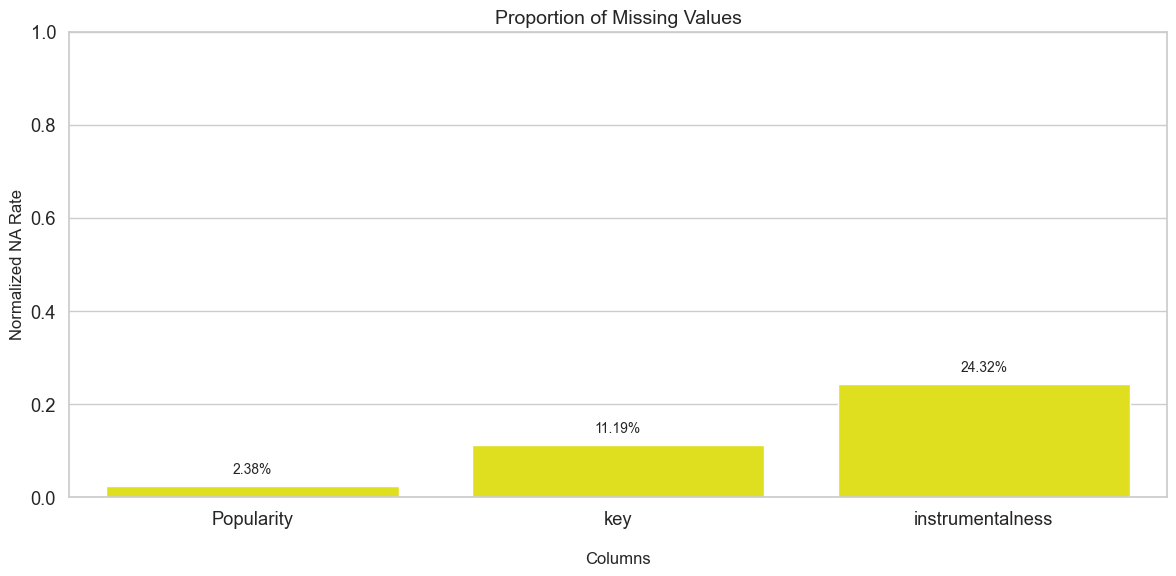

In [54]:
sns.set(style="whitegrid", font_scale=1.2)
plt.figure(figsize=(12, 6))

sns.barplot(data=na_values, x=na_values.index, y='NA Rate', color='yellow')

plt.xlabel('\nColumns', fontsize=12)
plt.ylabel('Normalized NA Rate', fontsize=12)
plt.title('Proportion of Missing Values', fontsize=14)
plt.ylim(0, 1.0)

for index, value in enumerate(na_values['NA Rate']):
    plt.text(index, value + 0.02, f'{value:.2%}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


Видно, что пропущенных значений очень много. Особенно в переменной `instrumentalness` - аж 24.32% пропущенных значений.<br>
Их слишком много, удалять четверть датасета слишком безрассудно. Однако, я решил ничего не делать с пропущенными значениями. Почему? Спойлер: показатели дерева от этого не сильно и пострадают. (А будут даже чуть выше).

#### **4. А есть ли дубликаты?**

In [57]:
print(f"There are {data.duplicated().sum()} duplicated rows!")

There are 0 duplicated rows!


Отлично!<br>

#### **5. Посмотрим на каждый тип переменных вблизи**

##### **5.1. Категориальные переменные**

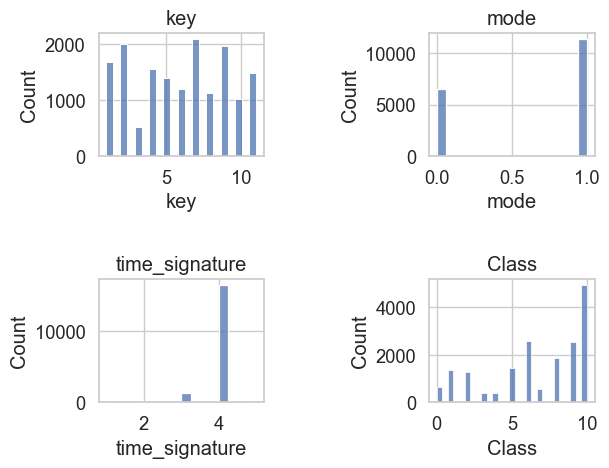

In [78]:
number=1
for i in categorical_features:
    plt.subplot(2, 2, number)
    sns.histplot(data[i])
    plt.title(i)
    number += 1
plt.subplots_adjust(wspace=1, hspace=1)

Вывод - все категориальные переменные `несбалансированны`.

#### **5.2. Количественные переменные**

##### **5.2.1. Анализ дисперсии**

In [79]:
data[numerical_features].describe()

,Popularity,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms
count,17568.000000,17996.000000,17996.000000,17996.000000,17996.000000,17996.000000,13619.000000,17996.000000,17996.000000,17996.000000,1.799600e+04
mean,44.512124,0.543433,0.662777,-7.910660,0.079707,0.247082,0.177562,0.196170,0.486208,122.623294,2.007445e+05
std,17.426928,0.166268,0.235373,4.049151,0.083576,0.310632,0.304048,0.159212,0.240195,29.571527,1.119891e+05
min,1.000000,0.059600,0.000020,-39.952000,0.022500,0.000000,0.000001,0.011900,0.018300,30.557000,5.016500e-01
25%,33.000000,0.432000,0.509000,-9.538000,0.034800,0.004300,0.000089,0.097500,0.297000,99.620750,1.663370e+05
50%,44.000000,0.545000,0.700000,-7.016000,0.047400,0.081400,0.003910,0.129000,0.481000,120.065500,2.091600e+05
75%,56.000000,0.659000,0.860000,-5.189000,0.083000,0.434000,0.200000,0.258000,0.672000,141.969250,2.524900e+05
max,100.000000,0.989000,1.000000,1.355000,0.955000,0.996000,0.996000,1.000000,0.986000,217.416000,1.477187e+06


Видна разница дисперсии всех данных.<br>
Возможно нужно будет `стандиртизировать` данные.

##### **5.2.2. Посмотрим на распределение данных**

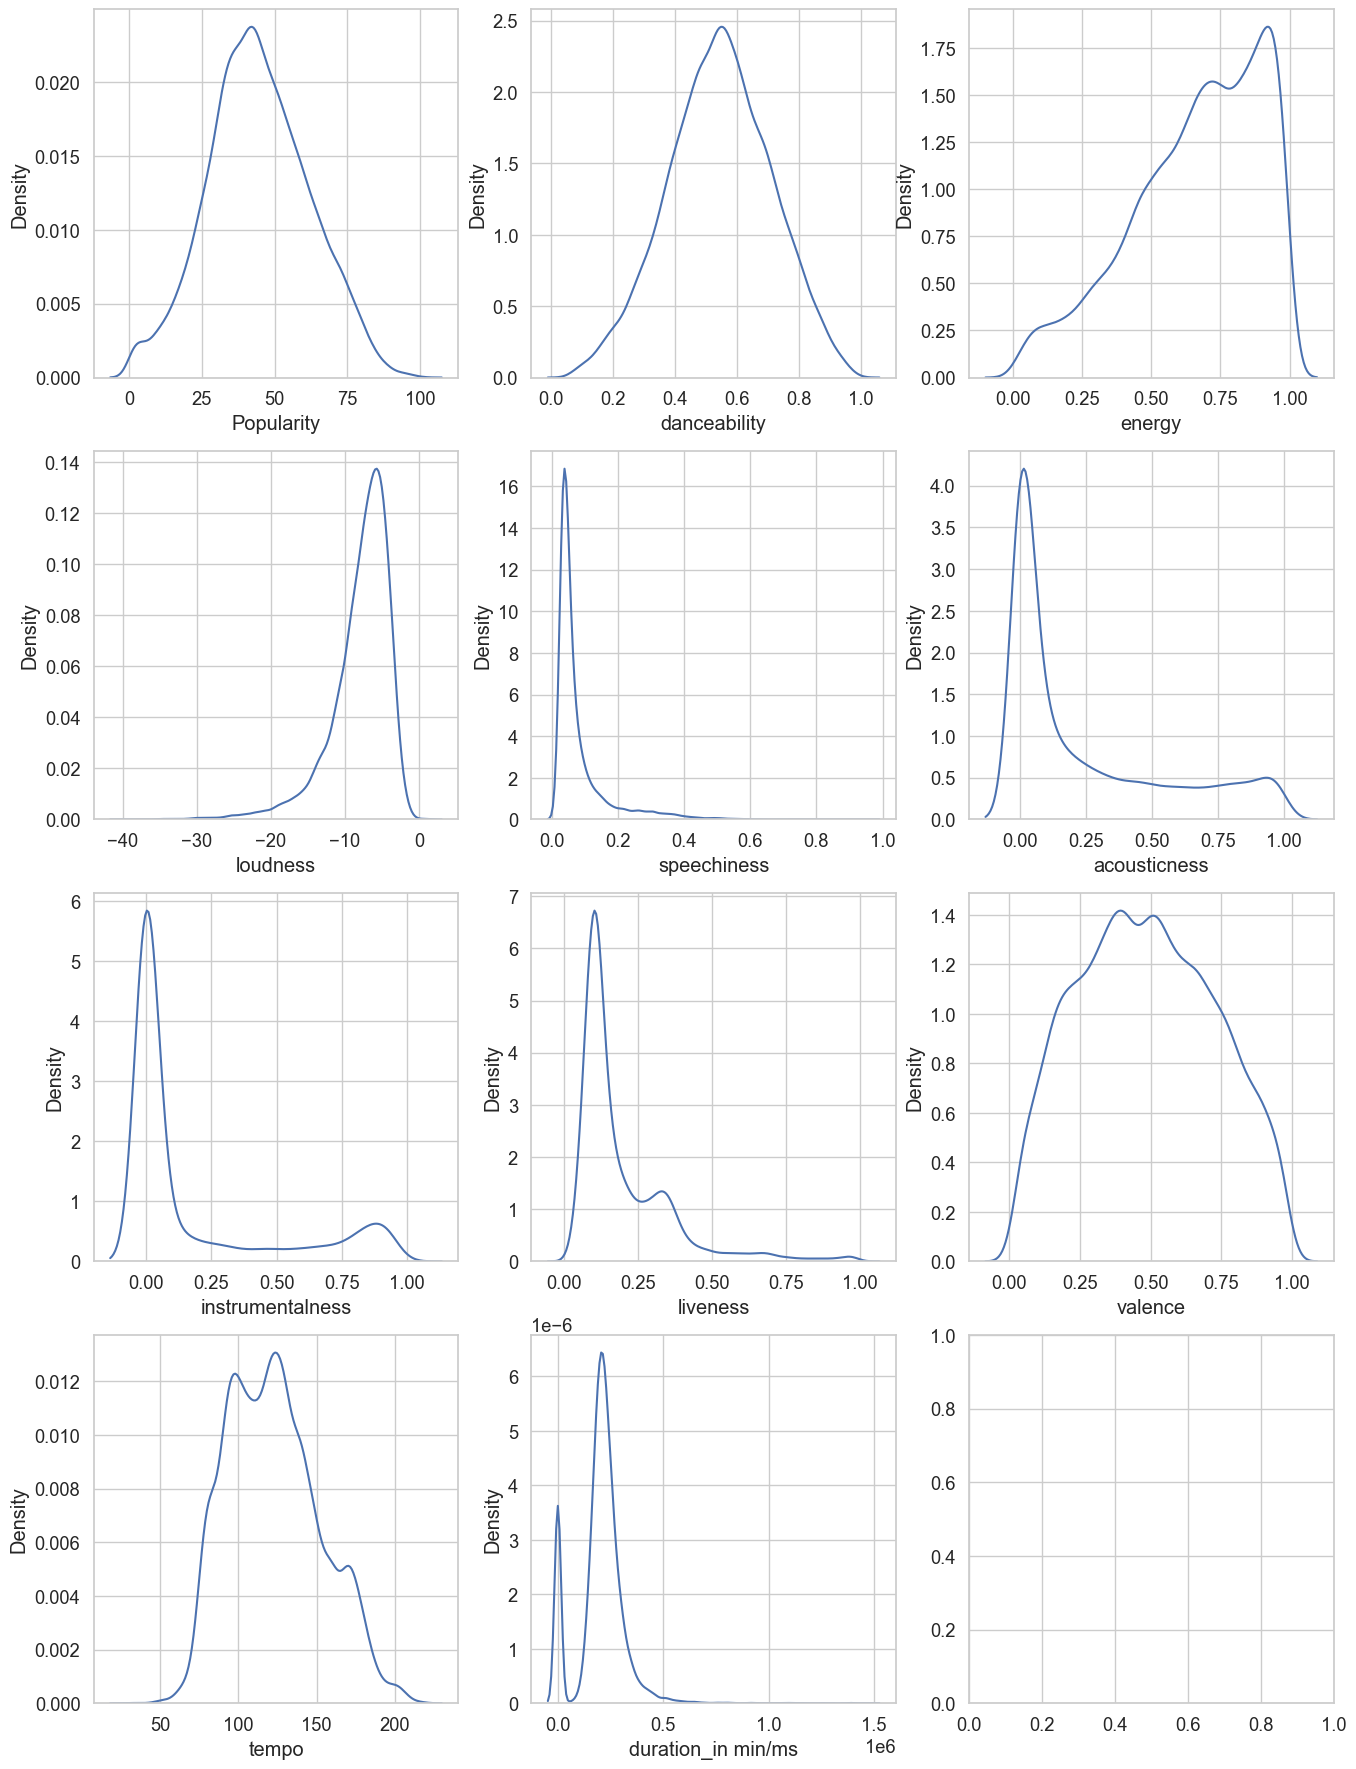

In [97]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(16, 22))
number = 0
for nrow in range(4):
    for ncol in range(3):
        if number == 11:
            break
        sns.kdeplot(data[numerical_features[number]], ax=axes[nrow][ncol])
        number += 1

1. Только 2 признака (`Popularity` и `danceability`) похожи на нормальное распределение. Остальные распределены ненормально.
2. Нужно привести в общей единице измерения данные в переменной `duration_in min/ms`]

###### **5.2.2.1. Приведем к общей единице измерения данные в переменной `duration_in min/ms`**

In [5]:
data.loc[data['duration_in min/ms'] > 10000, 'duration_in min/ms'] /= (1000 * 60)
data.rename(columns={'duration_in min/ms': 'duration_min'}, inplace=True)

###### **5.2.2.2. Обновим список `numerical features`**

In [6]:
target_index = numerical_features.index('duration_in min/ms')
numerical_features[target_index] = "duration_min"

###### **5.2.2.2. Вновь посмотрим на распределение данных в переменной `duration_in min`**

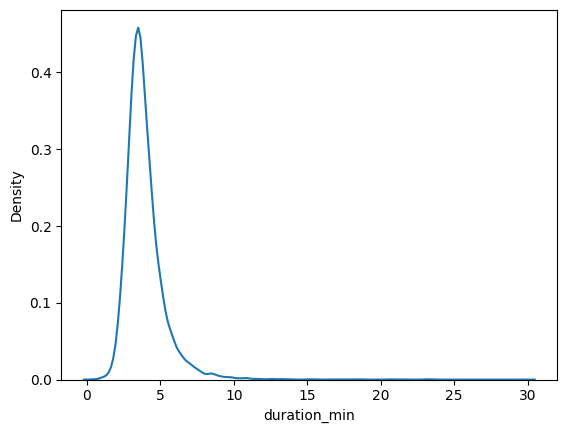

In [13]:
sns.kdeplot(data['duration_min'])
plt.show()

О!

##### **5.2.3. Посмотрим на выбросы**

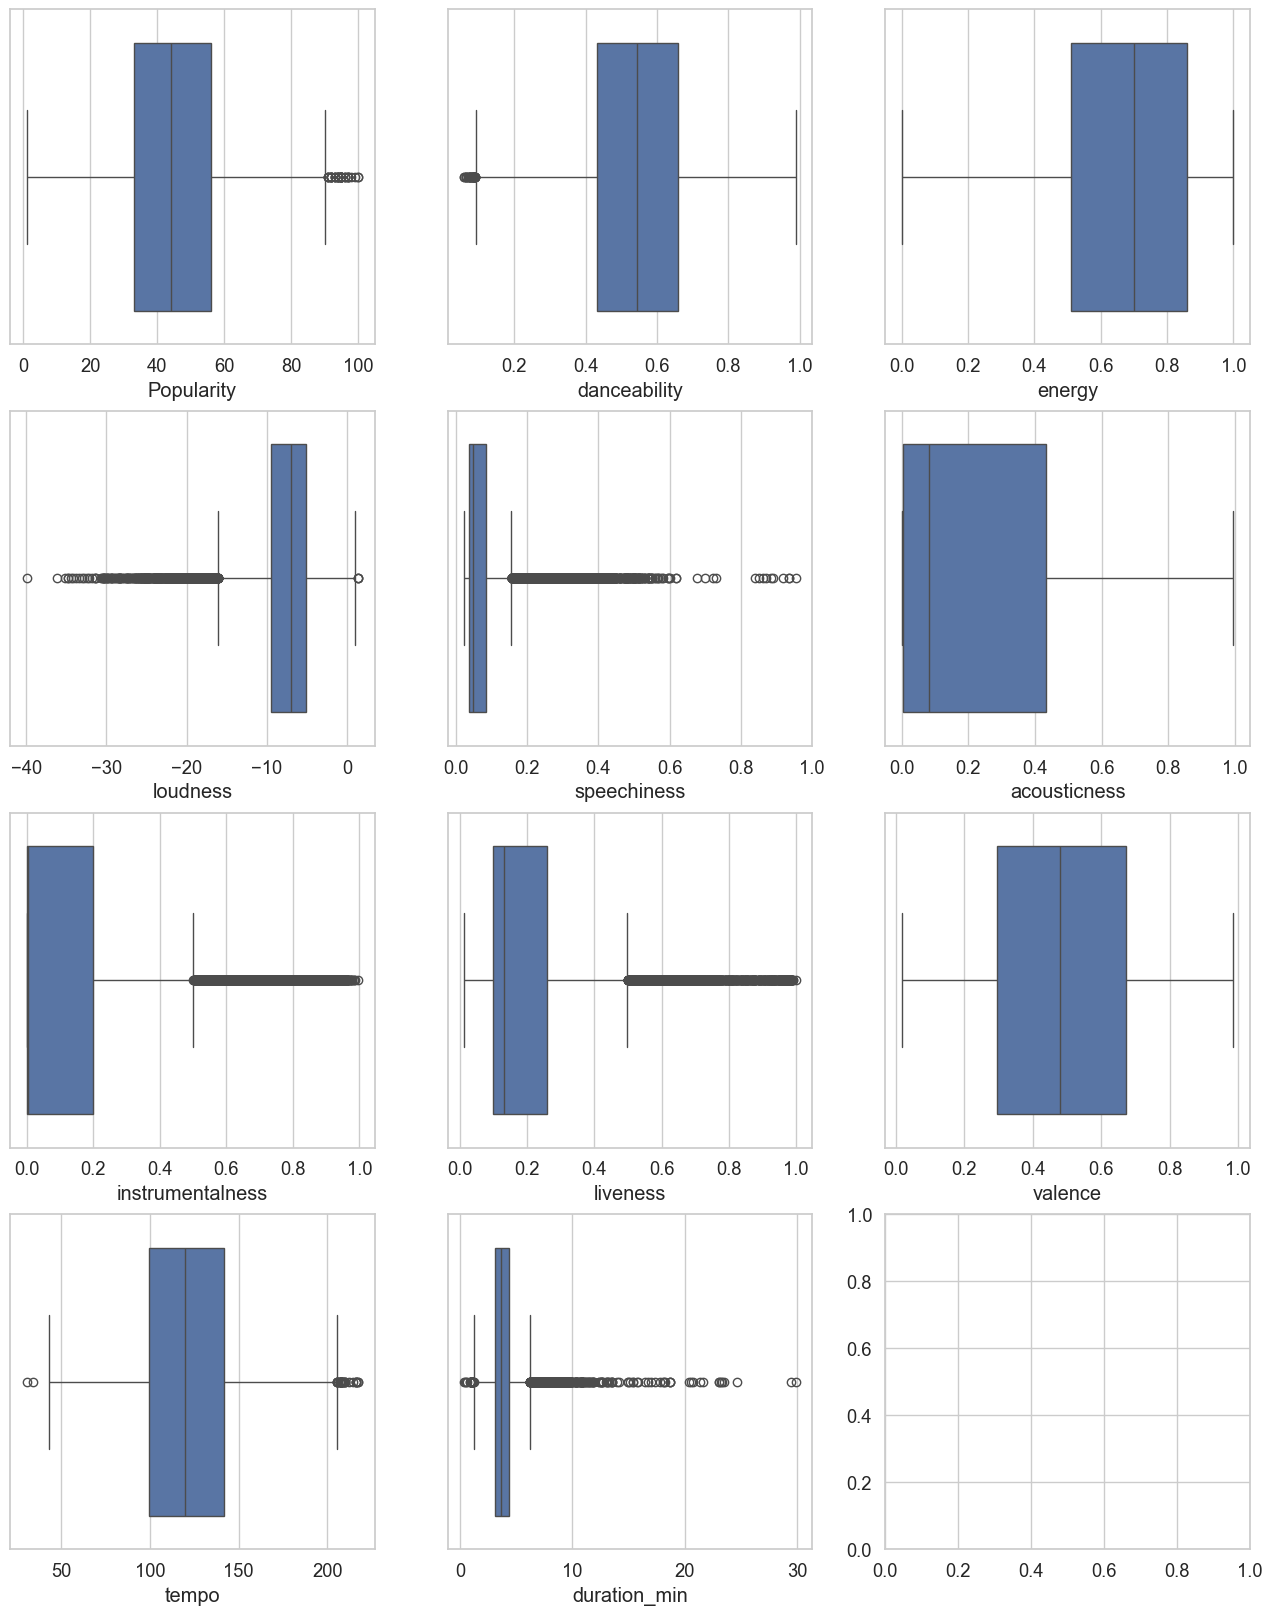

In [121]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(16, 20))
number = 0
for nrow in range(4):
    for ncol in range(3):
        if number == 11:
            break
        sns.boxplot(x=data[numerical_features[number]], ax=axes[nrow][ncol])
        number += 1

Меня немного смущает, что в нашем датасете есть прям очень длинные песни. В среднем, музыкальные треки длятся минут 3-5. Но старые треки бывали и длинные. Давайте посмотрим на то, сколько много у нас треков длиннее 15 минут.

In [126]:
data[data.duration_min > 15].shape[0]

29

In [141]:
data[data.duration_min > 15].head(3)

,Artist Name,Track Name,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_min,time_signature,Class
530,Pinkshinyultrablast,Songs,42.0,0.120,0.870,9.0,-6.984,1,0.0995,0.0018,0.8150,0.0834,0.0536,179.815,15.836833,3,6
696,Angel Bat Dawid,Harkening Etudes,22.0,0.622,0.394,10.0,-11.777,1,0.1150,0.8350,0.0181,0.1820,0.2430,120.089,18.062583,5,6
1219,"Amitabh Bachchan, Pran",Sir Main Vijay Bol Raha Hun - Dialogues,2.0,0.396,0.347,8.0,-15.483,1,0.3730,0.9500,0.2890,0.3980,0.4970,73.548,29.450000,4,3


Простым гуглением выяснил, что по крайней мере эти 3 трека действительно существуют. Что ж. Не буду трогать выбросы тогда.

##### **5.2.4. Посмотрим на корреляцию**

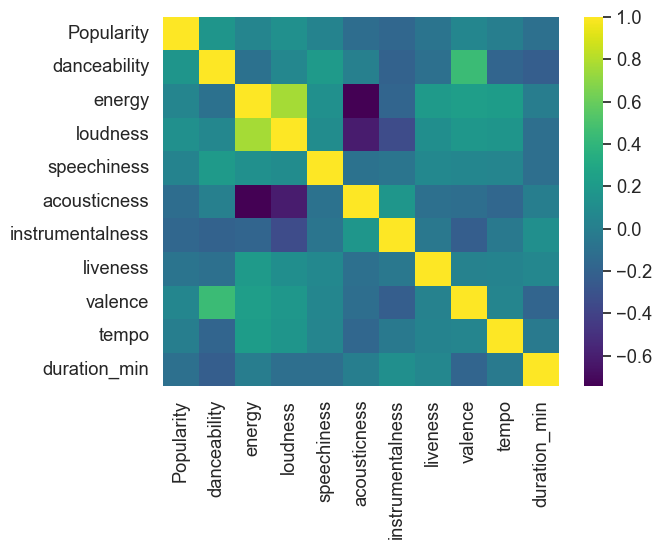

In [140]:
sns.heatmap(data[numerical_features].corr(), cmap='viridis');

Выводы:
1. `loudness` положительно коррелирует с `energy`<br>
Вполне логично.
2. `acousticness` отрицательно коррелирует с `energy`<br>
Пока не могу объяснить

Оставлю все переменные.

### Задание 2. Обучение дерева решений (10 баллов)

Предобработайте признаки так, чтобы их можно было подать в модель дерева решений и обучите ее, постарайтесь подобрать оптимальные гиперпараметры, которые вам известны. Постарайтесь также обосновать выбор метрики в данном случае. При подборе гиперпараметров может помочь `GridSearchCV` [ссылка](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

1. Я буду ориентироваться на метрику `F1 score weighted`<br>
Потому что у нас много несбалансированных классов. И эта метрика подходит лучше всего.
2. Я не буду включать в `X` и `y` - `Artist Name`.<br>

#### **2.1 Заполняем NA и стандартизируем данные**

In [21]:
X, y = data.iloc[:, 2:16], data.iloc[:, 16]

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.33,
                                                    random_state=SEED)

In [23]:
preprocessor = ColumnTransformer(transformers = [
    ('imp_num', SimpleImputer(strategy="mean"), ['Popularity', 'instrumentalness']),
    ('imp_cat', SimpleImputer(strategy='most_frequent'), ['key']),
    ('scaler', StandardScaler(), ['Popularity', 'loudness', 'tempo', 'duration_min'])
])

pipeline = Pipeline(steps = [
    ('preprocessor', preprocessor), 
    ('classifier', DecisionTreeClassifier())
])

In [24]:
parameters = {
    'classifier__max_depth': list(range(1, 15)),
    'classifier__min_samples_split':list(range(2, 5)),
    'classifier__min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(pipeline, parameters, cv=5, scoring='f1_weighted', n_jobs=8)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('imp_num',
                                                                         SimpleImputer(),
                                                                         ['Popularity',
                                                                          'instrumentalness']),
                                                                        ('imp_cat',
                                                                         SimpleImputer(strategy='most_frequent'),
                                                                         ['key']),
                                                                        ('scaler',
                                                                         StandardScaler(),
                                                                         ['Popularity',
                                                                          'loudness',
                                                                          'tempo',
                                                                          'duration_min'])])),
                                       ('classifier',
                                        DecisionTreeClassifier())]),
             n_jobs=8,
             param_grid={'classifier__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13, 14],
                         'classifier__min_samples_leaf': [1, 2, 4],
                         'classifier__min_samples_split': [2, 3, 4]},
             scoring='f1_weighted')

In [25]:
print("Best params:", grid_search.best_params_)
print("Best F1 score:", grid_search.best_score_)

Best params: {'classifier__max_depth': 8, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 4}
Best F1 score: 0.29455471650622317


Это вообще какой-то ужас. Я даже дальше идти не хочу `F1 score` = 0.2945. BRUH.

#### **2.1 Никак не обрабатываем данные**

In [34]:
pipeline = Pipeline(steps=[
    ('classifier', DecisionTreeClassifier())
])

param_grid = {
    'classifier__max_depth': list(range(1, 15)),
    'classifier__min_samples_split':list(range(2, 5)),
    'classifier__min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(pipeline, parameters, cv=5, scoring='f1_weighted', n_jobs=8)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('classifier',
                                        DecisionTreeClassifier())]),
             n_jobs=8,
             param_grid={'classifier__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13, 14],
                         'classifier__min_samples_leaf': [1, 2, 4],
                         'classifier__min_samples_split': [2, 3, 4]},
             scoring='f1_weighted')

In [49]:
print("Best hyperparams:", grid_search.best_params_)
print("Best F1 score:", grid_search.best_score_)

Best hyperparams: {'classifier__max_depth': 9, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2}
Best F1 score: 0.39392759114027104


Во! Уже лучше. Значит двигаемся дальше.

In [36]:
pipeline_2 = Pipeline(steps=[
    ('classifier', grid_search.best_estimator_.named_steps['classifier'])
])

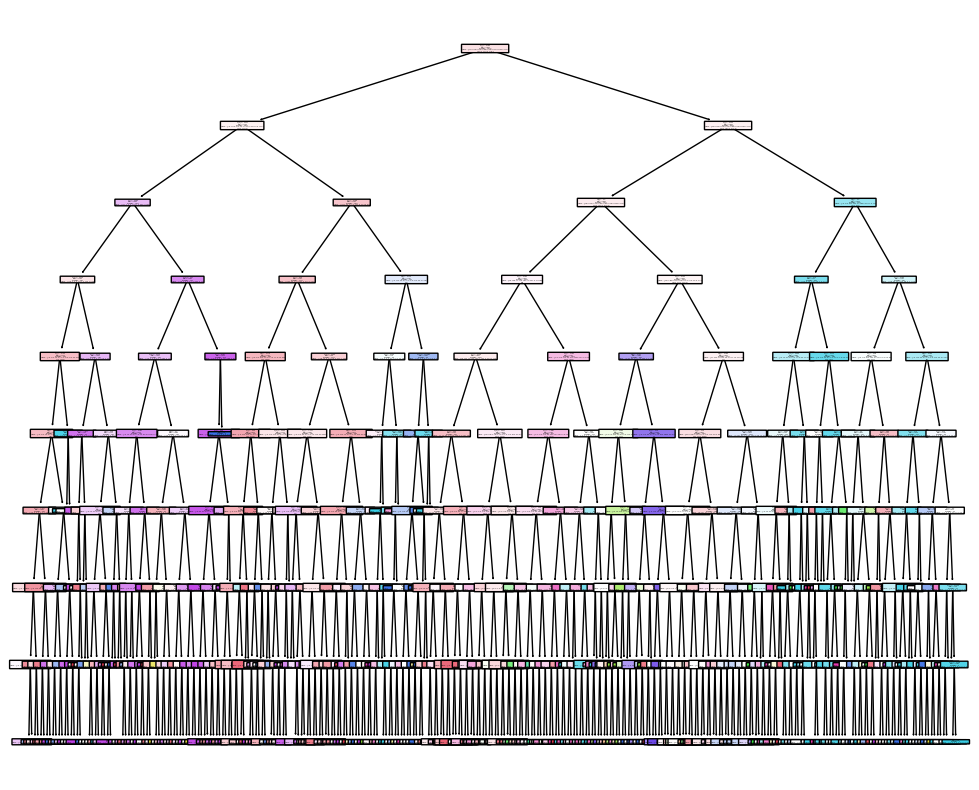

In [44]:
decision_tree_fig = pipeline_2['classifier']

plt.figure(figsize=(12, 10))
plot_tree(decision_tree_fig, filled=True, rounded=True)
plt.show()

In [67]:
y_predict = pipeline_2.predict(X_test)

accuracy = accuracy_score(y_test, y_predict)
precision = precision_score(y_test, y_predict, average='weighted')
recall = recall_score(y_test, y_predict, average='weighted')
f1 = f1_score(y_test, y_predict, average='weighted')

print(f'Accuracy: {accuracy:}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

Accuracy: 0.42970197002862437
Precision: 0.39988378383684314
Recall: 0.42970197002862437
F1 Score: 0.3999481373212046


Что ж. Дерево не самое лучшее. Да, `F1 Score` уже 3.9, а не 2.9. Это лучше, но не прям чтобы отвал челюсти. Кажется, что можно поиграться с гиперпараметрами и дальше, но у меня осталось 15 минут до дедлайна...

### Задание 3. Другие модели (без баллов, просто если есть желание)

Проделайте операции из **Задания 2** с другими известными вам классификаторами. Стало ли лучше?

### Задание 4. (0.5 доп. балла)

Расскажите про свои любимые фильмы, мультики и тд.

1. Аватар: Легенда об Аанге (оригинал)

2. Атака Титанов (особенно третий сезон и серия с речью Эрвина Смитта)

3. Five Nights at Freddy's (фильм)

Не знаю, стоит ли объяснять шедевральность каждого из этих чудных произведений.